In [153]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import numpyro
from numpyro import distributions as dist
from numpyro import infer

from numpyro_ext import distributions as distx
from numpyro_ext import info, optim

jax.config.update("jax_enable_x64", True)
numpyro.set_host_device_count(2)

from jaxoplanet import light_curves, orbits
import arviz as az
import corner

from eclipsoid.light_curve import legacy_oblate_lightcurve
legacy_oblate_lightcurve = jax.jit(legacy_oblate_lightcurve)
from astropy.table import Table
import pandas as pd

from jaxoplanet import light_curves, orbits
from jaxoplanet.light_curves import limb_dark_light_curve
import arviz as az
import corner
oblate_lightcurve = jit(legacy_oblate_lightcurve)
grad = jit(jax.jacrev(legacy_oblate_lightcurve))

In [3]:
planet_pop = pd.read_csv("planet_pop.csv",header=149)
planet_pop

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,tran_flag,soltype,...,sy_gaiamagerr2,sy_tmag,sy_tmagerr1,sy_tmagerr2,sy_kepmag,sy_kepmagerr1,sy_kepmagerr2,rowupdate,pl_pubdate,releasedate
0,Kepler-827 b,Kepler-827,1,1,1,Transit,2016,Kepler,1,Published Confirmed,...,-0.000572,15.35150,0.0077,-0.0077,15.897,NaN,NaN,2016-05-06,2016-05,2016-05-10
1,Kepler-516 b,Kepler-516,1,1,1,Transit,2016,Kepler,1,Published Confirmed,...,-0.000175,11.65160,0.0078,-0.0078,12.059,NaN,NaN,2016-05-06,2016-05,2016-05-10
2,EPIC 211945201 b,EPIC 211945201,1,1,1,Transit,2018,K2,1,Published Confirmed,...,-0.000372,9.66896,0.0061,-0.0061,10.115,NaN,NaN,2018-10-24,2018-12,2018-10-26
3,HD 152843 c,HD 152843,1,1,2,Transit,2021,Transiting Exoplanet Survey Satellite (TESS),1,Published Confirmed,...,-0.000237,8.40302,0.0060,-0.0060,NaN,NaN,NaN,2021-06-11,2021-05,2021-06-11
4,Kepler-122 c,Kepler-122,1,1,5,Transit,2014,Kepler,1,Published Confirmed,...,-0.000249,13.78670,0.0078,-0.0078,14.247,NaN,NaN,2014-05-14,2014-03,2014-05-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,Kepler-427 b,Kepler-427,1,1,1,Transit,2014,Kepler,1,Published Confirmed,...,-0.000266,13.75600,0.0066,-0.0066,14.221,NaN,NaN,2014-10-03,2014-12,2014-10-03
187,Kepler-39 b,Kepler-39,1,1,1,Transit,2011,Kepler,1,Published Confirmed,...,-0.000275,13.82610,0.0098,-0.0098,14.327,NaN,NaN,2015-01-29,2015-03,2015-01-29
188,HD 206893 b,HD 206893,1,1,2,Imaging,2021,Gemini Observatory,0,Published Confirmed,...,-0.000320,6.25660,0.0060,-0.0060,NaN,NaN,NaN,2022-12-05,2022-08,2022-12-05
189,HD 206893 c,HD 206893,1,1,2,Imaging,2022,European Southern Observatory,0,Published Confirmed,...,-0.000320,6.25660,0.0060,-0.0060,NaN,NaN,NaN,2022-12-05,2022-08,2022-12-05


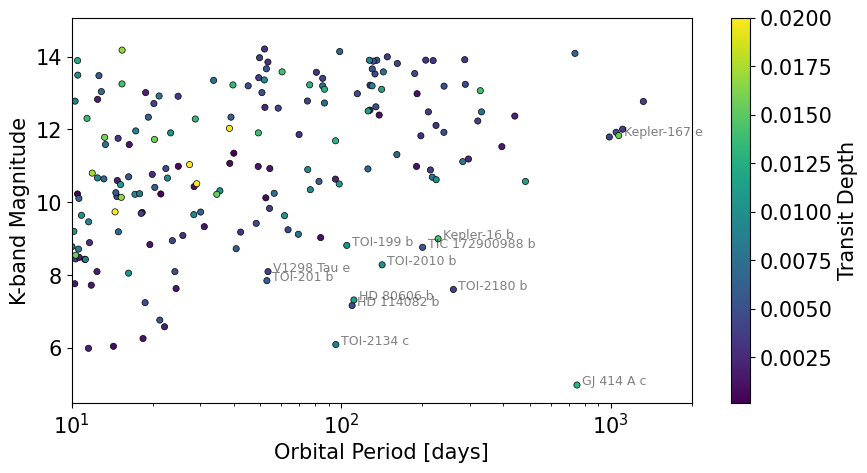

In [4]:
c = (0.102763*planet_pop['pl_radj'] / planet_pop['st_rad'])**2
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plot = ax.scatter(planet_pop['pl_orbper'],planet_pop['sy_kmag'],c=c,s=20,cmap='viridis',edgecolors='k',linewidths=0.5,vmax=0.02)
ax.set_xscale('log')
ax.set_xlim(10,2000)
plt.colorbar(plot,label='Transit Depth')

ax.set_xlabel('Orbital Period [days]')
ax.set_ylabel('K-band Magnitude')
for i in range(0,len(planet_pop)):
    if planet_pop['pl_name'][i] == 'Kepler-167 e':
        ax.annotate(planet_pop['pl_name'][i],(planet_pop['pl_orbper'][i],planet_pop['sy_kmag'][i]), fontsize=9,alpha=0.5,textcoords='offset pixels',xytext=(5,0))
    if planet_pop['pl_orbper'][i] > 50 and planet_pop['sy_kmag'][i] < 9:
        ax.annotate(planet_pop['pl_name'][i],(planet_pop['pl_orbper'][i],planet_pop['sy_kmag'][i]), fontsize=9,alpha=0.5,textcoords='offset pixels',xytext=(5,0))
plt.savefig('param_space.png',dpi=300)


 ** On entry to ZGEBAL parameter number  3 had an illegal value
 ** On entry to ZGEHRD parameter number  2 had an illegal value
 ** On entry to ZUNGHR parameter number  2 had an illegal value
 ** On entry to ZHSEQR parameter number  4 had an illegal value
 ** On entry to ZGEBAL parameter number  3 had an illegal value
 ** On entry to ZGEHRD parameter number  2 had an illegal value
 ** On entry to ZUNGHR parameter number  2 had an illegal value
 ** On entry to ZHSEQR parameter number  4 had an illegal value
 ** On entry to ZGEBAL parameter number  3 had an illegal value
 ** On entry to ZGEHRD parameter number  2 had an illegal value
 ** On entry to ZUNGHR parameter number  2 had an illegal value
 ** On entry to ZHSEQR parameter number  4 had an illegal value
 ** On entry to ZGEBAL parameter number  3 had an illegal value
 ** On entry to ZGEHRD parameter number  2 had an illegal value
 ** On entry to ZUNGHR parameter number  2 had an illegal value
 ** On entry to ZHSEQR parameter number 

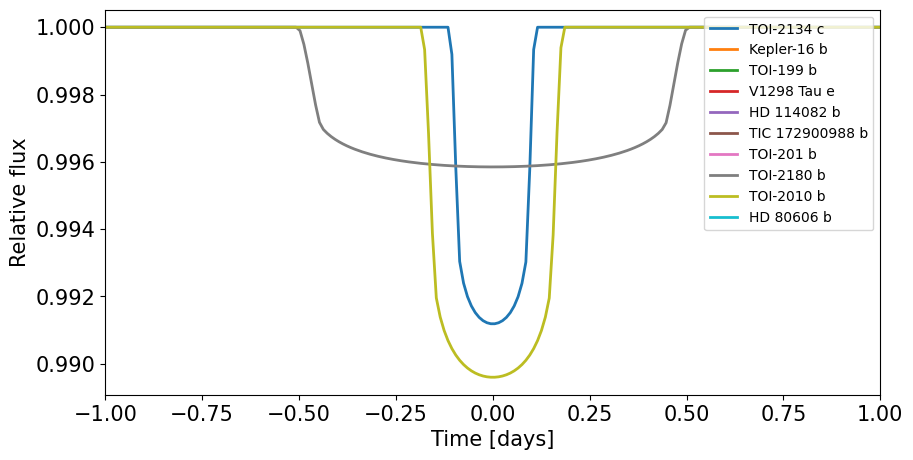

In [6]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
index_list = {}
for i in range(len(planet_pop)):
        if planet_pop['pl_orbper'][i] > 50 and planet_pop['sy_kmag'][i] < 9 and planet_pop['pl_orbper'][i] < 300:
                params = {'period':planet_pop['pl_orbper'][i],
                        'radius':(0.102763*planet_pop['pl_radj'][i] / planet_pop['st_rad'][i]),
                        'u':jnp.array([0.3,0.2]),
                        'f':0.1,
                        'bo':planet_pop['pl_imppar'][i],
                        'theta':0.6,
                        'duration':planet_pop['pl_trandur'][i]/24,
                }
                index_list[planet_pop['pl_name'][i]] = [i,params]

                # The light curve calculation requires an orbit

                t = jnp.linspace(-1.0, 1.0, 200)
                lc = oblate_lightcurve(params,t)

                ax.plot(t, lc, lw=2,label = planet_pop['pl_name'][i])
                ax.set_ylabel("Relative flux")
                ax.set_xlabel("Time [days]")
plt.legend(loc='upper right',fontsize=10)
_ = plt.xlim(t.min(), t.max())

In [94]:
def calc_T14(inc, a, per, rp, rs):
    rs = rs*109.076
    a = a*23454.8
    b = jnp.cos(jnp.radians(inc))*a/(rs)
    rat = rp/(rs)
    t14 = per/np.pi* rs/a * np.sqrt((1+rat)**2 - b**2)
    return t14
def bo_func(a,rs,inc):
    a = a*23454.8
    rs = rs*109.076
    return jnp.abs(a*jnp.cos(jnp.deg2rad(inc))/rs)

TOI-2010 b
{'period': 141.834025, 'radius': 0.10028907592592591, 'u': Array([0.3, 0.2], dtype=float64), 'f': 0.1, 'bo': Array(0.18593105, dtype=float64), 'theta': 0.6, 'duration': 0.4458024082373336}


/var/folders/4b/sq0slnz147sfy_kz1_nwf6zh0000gn/T/ipykernel_28542/729880257.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  noise = float(noise)


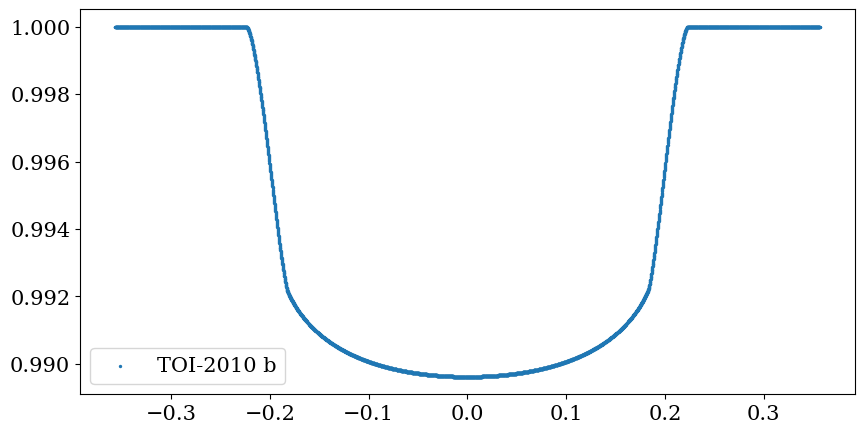

In [175]:
df_noise_pop = pd.read_csv("/Users/shishir/Documents/Astronomy/USQ/eclipsoid/notebooks/jexosim_niriss_soss_gr700xd_point_to_point_scatter.csv")
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
counter=0
failed=""
i=41
if str(df_noise_pop['Planet Name'][i]) in list(planet_pop['pl_name']):
        planet_name = df_noise_pop['Planet Name'][i]
        index = planet_pop.loc[planet_pop['pl_name'] == planet_name].index[0]
        dur = calc_T14(planet_pop['pl_orbincl'][index],planet_pop['pl_orbsmax'][index],planet_pop['pl_orbper'][index],planet_pop['pl_rade'][index],planet_pop['st_rad'][index])
        bo = bo_func(planet_pop['pl_orbsmax'][index],planet_pop['st_rad'][index],planet_pop['pl_orbincl'][index])
        print(planet_name)
        if not jnp.isnan(dur) and not jnp.isnan(bo):
                params = {'period':planet_pop['pl_orbper'][index],
                'radius':(0.102763*planet_pop['pl_radj'][index] / planet_pop['st_rad'][index]),
                'u':jnp.array([0.3,0.2]),
                'f':0.1,
                'bo':bo,
                'theta':0.6,
                'duration':dur
        }
                print(params)
                cadence = df_noise_pop.loc[df_noise_pop['Planet Name'] == planet_name]['t_cycle'].iloc[0]/86400

                t = jnp.arange(-0.8*dur, 0.8*dur, cadence) #jnp.linspace(-0.8*dur, 0.8*dur,1000)
                lc = oblate_lightcurve(params,t)
                noise = df_noise_pop.loc[df_noise_pop['Planet Name'] == planet_name]["sigma_ppm"]
                noise = float(noise)
                noise = noise/1e6
                noise_arr = jax.random.normal(jax.random.PRNGKey(0), shape=(len(t),))*noise
                lc = lc#+ noise_arr
                ax.scatter(t, lc, s=2,label = planet_name)
                counter+=1
else:
        failed+=planet_name
plt.legend()

In [176]:
import zodiax as zdx
from eclipsoid.utils import zero_safe_arctan2

class OblateTransitModel(zdx.Base):
    period: jnp.ndarray
    t0: jnp.ndarray
    r_circ: jnp.ndarray
    u: jnp.ndarray
    bo: jnp.ndarray
    duration: jnp.ndarray
    t: jnp.ndarray
    h: jnp.ndarray
    k: jnp.ndarray
    f: jnp.ndarray
    theta: jnp.ndarray
    
    def __init__(self, period, t0, r_circ, u, h, bo, k, duration, t):
        self.period = period
        self.r_circ = r_circ
        self.t0 = t0
        self.u = u
        self.h = h
        self.bo = bo
        self.k = k
        self.duration = duration
        self.t = t
        self.f = (self.h**2 + self.k**2)/2.
        self.theta = zero_safe_arctan2(self.k,self.h)/2.
        
    def model(self):
      f = (self.h**2 + self.k**2)/2.
      theta = zero_safe_arctan2(self.k,self.h)/2.
      #Compute a limb-darkened light curve using starry
      params = {'period':self.period,
                't0':self.t0,
                'radius':jnp.sqrt(self.r_circ**2/(1-f)),
                'u':self.u,
                'f':f,
                'bo':self.bo,
                'theta':theta,
                'duration': self.duration
        }
      lc = oblate_lightcurve(params,self.t)
      return lc

In [177]:
h = 2*jnp.sqrt(params['f']/2)*np.cos(2*params['theta'])
k = 2*jnp.sqrt(params['f']/2.)*np.sin(2*params['theta'])
model = OblateTransitModel(params['period'], 0, params['radius']*jnp.sqrt((1-params['f'])), params['u'], h, params['bo'], k, params['duration'], t)

In [178]:
def custom_loglike(model, data, noise):
    sigma2 = noise**2
    return 0.5*np.sum((data - model.model()) ** 2 / sigma2)

In [179]:
custom_loglike(model, lc, noise)

Array(1.89461394e-16, dtype=float64)

In [180]:
from chainconsumer import ChainConsumer

opt_params = ['h','k', 'r_circ', 'bo', 'duration','u']

cov = zdx.covariance_matrix(model, opt_params, custom_loglike, lc, noise=noise)

/Users/shishir/opt/anaconda3/envs/py39/lib/python3.9/site-packages/chainconsumer/chainconsumer.py:346: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  chain = np.random.multivariate_normal(mean, covariance, size=1000000)


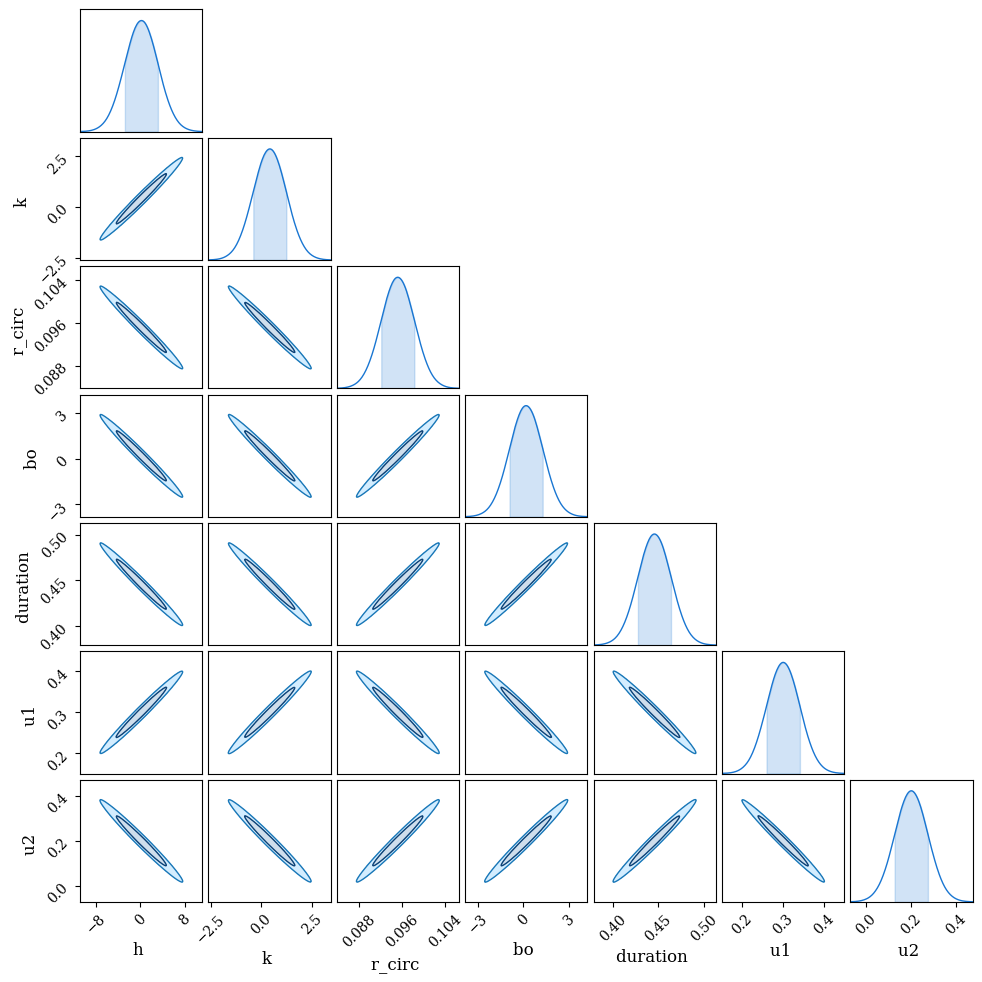

In [181]:
X = np.array([model.h,model.k, model.r_circ, model.bo, model.duration, model.u[0],model.u[1]])
c = ChainConsumer()
c.add_covariance(X, cov, parameters=['h','k', 'r_circ', 'bo', 'duration','u1','u2'], name='Fisher info')
c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)
fig = c.plotter.plot()

In [152]:
h,k = -.10, 0.32
(h**2 + k**2)/2.

0.0562

In [146]:
(model.h**2 + model.k**2)/2

Array(0.1, dtype=float64)

In [147]:
model.k

Array(0.41682055, dtype=float64)

In [148]:
noise

8.109977352432907e-05